# Halo profiles
This example illustrate how to use CCL to calculate halo profiles (and quantities associated to them)

In [1]:
import numpy as np
import pyccl as ccl
import pylab as plt
import matplotlib.cm as cm
%matplotlib inline

## Preliminaries
Generate a cosmology object and a couple of $r$ (comoving radius), $k$ (comoving wavenumber) and $M$ (halo mass) arrays.

In [2]:
# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

# Radius, wavenumber and mass
r_arr = np.geomspace(1E-2,1E2,256)
k_arr = np.geomspace(1E-2,1E2,256)
m_arr = np.geomspace(1E11,1E15,32)

# We will calculate everything at z=1 (scale factor = 0.5)
a_sf = 0.5

# We will also use a mass definition with Delta = 200, and the Duffy 2008 concentration-mass relation
hmd_200c = ccl.halos.MassDef200c()
cM = ccl.halos.ConcentrationDuffy08(hmd_200c)

## Halo profile classes
All halo profiles are sub-classes of the base `HaloProfile` class. CCL currently supports the following halo profiles:
- `HaloProfileNFW`: the Navarro-Frenk-White density profile.
- `HaloProfileEinasto`: the Einasto profile.
- `HaloProfileHernquist`: the Hernquist profile.
- `HaloProfileGaussian`: a toy Gaussian profile.
- `HaloProfilePowerLaw`: a toy power-law profile.

However, the API is flexible enough for you to implement your own halo profiles. See further down.

For now, let's compare the first three profiles.

In [3]:
profs = {}
profs['NFW'] = ccl.halos.HaloProfileNFW(cM, truncated=False)
profs['Einasto'] = ccl.halos.HaloProfileEinasto(cM, truncated=False)
profs['Hernquist'] = ccl.halos.HaloProfileHernquist(cM, truncated=False)

First, let's just plot the real-space profile for all models

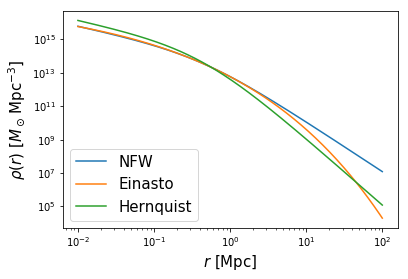

In [4]:
# Plot the real-space profile for a fixed mass of M = 1E14 M_sun
plt.figure()
for n,p in profs.items():
    rho_r = p.real(cosmo, r_arr, 1E14, a_sf, mass_def=hmd_200c)
    plt.plot(r_arr, rho_r, label=n)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=15)
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);

All the profile-related methods can take in an array of halo masses, and output the profile for all of them in a 2D array.

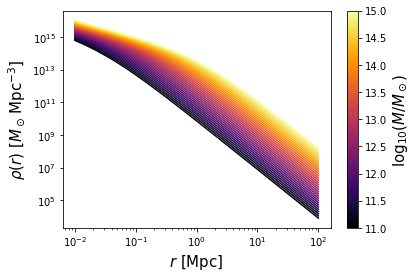

In [5]:
pM = profs['NFW'].real(cosmo,r_arr, m_arr, a_sf, mass_def=hmd_200c)
pM.shape

fig=plt.figure()
cmap = plt.cm.inferno
for i, p in enumerate(pM):
    plt.plot(r_arr, p, c=cmap((i + 0.5) / 32))
plt.xscale('log')
plt.yscale('log')
lm = np.log10(m_arr)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=lm.min(),
                                              vmax=lm.max()))
sm._A = []
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
cbar = fig.colorbar(sm)
cbar.set_label(r'$\log_{10}(M/M_\odot)$', fontsize=15)

## Derived quantities
Besides the 3D real-space profile, CCL can also calculate the Fourier-space profile ($\rho(k)$), the 2D projected profile ($\Sigma(R)$) and the cumulative surface density ($\Sigma(<R)$). These are defined as:

\begin{align}
   \rho(k) &= 4\pi\int_0^\infty dr\,r^2\,\rho(r)\,j_0(kr),\\
   \Sigma(R) &= \int_{-\infty}^\infty dr_\parallel\,\rho\left(\sqrt{r_\parallel^2+R^2}\right),\\
   \Sigma(<R) &= \frac{2}{R^2}\int_0^R\,dR'\,R'\,\Sigma(R).
\end{align}

CCL can compute these quantities automatically based on the 3D real-space profile (although you can also choose to calculate them analytically in some particular cases). To do so, CCL uses a fast `FFTLog`-based algorithm.


### Fourier profile

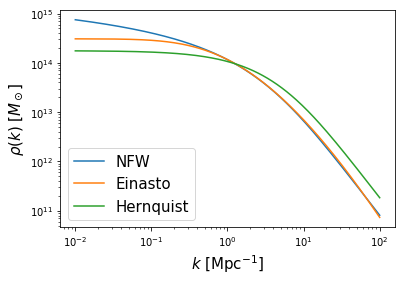

In [6]:
# Plot the Fourier-space profile for a fixed mass of M = 1E14 M_sun
plt.figure()
for n,p in profs.items():
    rho_k = p.fourier(cosmo, k_arr, 1E14, a_sf, mass_def=hmd_200c)
    plt.plot(k_arr, rho_k, label=n)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=15)
plt.ylabel(r'$\rho(k)\,\,[M_\odot]$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15);

### Projected profile

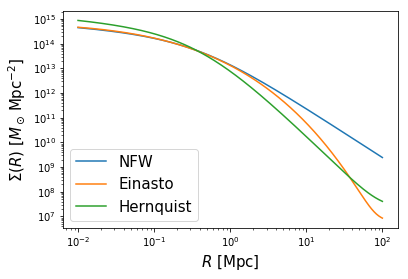

In [7]:
# Plot the projected profile for a fixed mass of M = 1E14 M_sun
plt.figure()
for n,p in profs.items():
    sig_R = p.projected(cosmo, r_arr, 1E14, a_sf, mass_def=hmd_200c)
    plt.plot(r_arr, sig_R, label=n)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=15)
plt.ylabel(r'$\Sigma(R)\,\,[M_\odot\,{\rm Mpc}^{-2}]$', fontsize=15)
plt.xlabel(r'$R\,\,[{\rm Mpc}]$', fontsize=15);

### Cumulative surface density

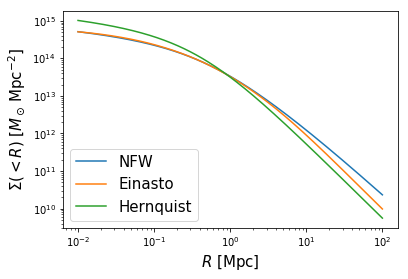

In [8]:
# Plot the projected profile for a fixed mass of M = 1E14 M_sun
plt.figure()
for n,p in profs.items():
    sig_lR = p.cumul2d(cosmo, r_arr, 1E14, a_sf, mass_def=hmd_200c)
    plt.plot(r_arr, sig_lR, label=n)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=15)
plt.ylabel(r'$\Sigma(<R)\,\,[M_\odot\,{\rm Mpc}^{-2}]$', fontsize=15)
plt.xlabel(r'$R\,\,[{\rm Mpc}]$', fontsize=15);

## Creating new profiles
Creating new profiles is relatively easy. In the simplest case you only need to create a class that inherits from `HaloProfile` and that contains a method called `_real` with the signature below. It should be able to take radii and masses as arrays or floats, and it should return a float, 1D array or 2D array (with shape `(n_radius, n_mass)` in the latter case) depending on the input.

To demonstrate this, let's define an "Lorentzian" profile. I.e.:

\begin{equation}
  \rho(r) = \rho_0\,\frac{r_s}{r}\,e^{-r/r_s},\hspace{12pt}\rho_0=\frac{M}{4\pi\,r_s^3}
\end{equation}

In [9]:
class HaloProfileLorentz(ccl.halos.HaloProfile):
    def __init__(self):
        super(HaloProfileLorentz, self).__init__()

    def _rs(self, cosmo, M, a, mdef):
        """ This defines the scale radius as a function
        of halo mass. For simplicity we just use the
        overdensity radius.
        """
        return mdef.get_radius(cosmo, M, a) / a

    def _real(self, cosmo, r, M, a, mass_def):
        """ Real space profile.
        
        Args:
            cosmo (obj:`Cosmology`): a cosmology object.
            r (float or array_like): halo radius.
            M (float or array_like): halo mass.
            a (float): scale factor.
            mass_def (obj:`MassDef`): mass definition.

       Returns:
            float or array_like: halo profile. The shape of the
            output will be `(N_M, N_r)` where `N_r` and `N_m` are
            the sizes of `r` and `M` respectively.
        """
        # Generate 2D array by default
        r_use = np.atleast_1d(r)
        M_use = np.atleast_1d(M)

        # Compute profile
        r_s = self._rs(cosmo, M_use, a, mass_def)
        rho0 = M_use / (4 * np.pi * r_s**3)
        x = r[None, :] / r_s[:, None]
        prof = rho0[:, None] * np.exp(-x) / x

        # Make sure the output has the right shape
        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
        return prof

Let's generate a profile and plot it.

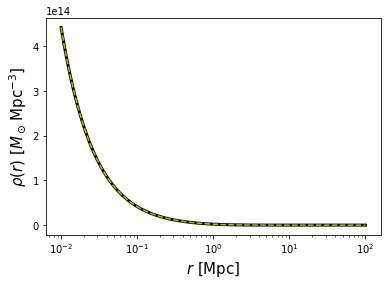

In [10]:
pl = HaloProfileLorentz()
rs = pl._rs(cosmo, 1E14, a_sf, hmd_200c)
rho0 = 1E14 / (4 * np.pi * rs**3)

# Plotting
plt.figure()
plt.plot(r_arr, pl.real(cosmo, r_arr, 1E14, a_sf, hmd_200c),
         'k-', lw=3)
# Let's compare with the expected shape
plt.plot(r_arr, rho0 * np.exp(-r_arr / rs) * rs / r_arr,
         'y--')
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15)
plt.xscale('log')

### Fourier profile
CCL can compute the Fourier-space profile automatically using FFTLog. Let us compare it with the analytical solution for this profile:

\begin{equation}
  \rho(k)=\frac{M}{1+(k r_s)^2}
\end{equation}

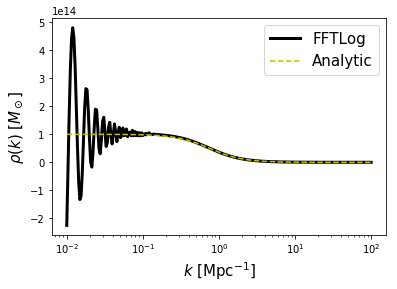

In [11]:
# FFTLog calculation
pk = pl.fourier(cosmo, k_arr, 1E14, a_sf, hmd_200c)
# Analytical prediction
pk_pred = 1E14 / (1 + (k_arr * rs)**2)

# Plot!
plt.plot(k_arr, pk,'k-', lw=3, label='FFTLog')
plt.plot(k_arr, pk_pred,'y--', label='Analytic')
plt.legend(loc='upper right', fontsize=15)
plt.ylabel(r'$\rho(k)\,\,[M_\odot]$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15);
plt.xscale('log')

FFTLog is obviously not doing a very good job here. We can improve the result by tweaking the FFTLog precision parameters through the `update_precision_fftlog` method. This will almost always be the case when you create a new profile if you want to rely on FFTLog to produce these predictions. Below we show how we can improve the results significantly doing this (see the documentation to understand what the different precision parameters do).

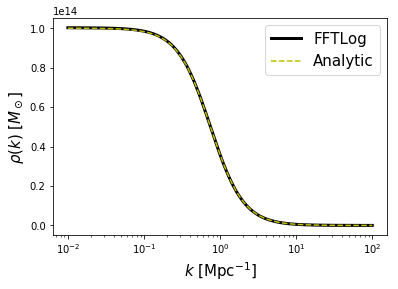

In [12]:
# Update parameters
pl.update_precision_fftlog(padding_hi_fftlog=1E2,
                           padding_lo_fftlog=1E-2,
                           n_per_decade=1000,
                           plaw_fourier=-2.)

# Recompute fourier profile
pk = pl.fourier(cosmo, k_arr, 1E14, a_sf, hmd_200c)

# Replot!
plt.plot(k_arr, pk,'k-', lw=3, label='FFTLog')
plt.plot(k_arr, pk_pred,'y--', label='Analytic')
plt.legend(loc='upper right', fontsize=15)
plt.ylabel(r'$\rho(k)\,\,[M_\odot]$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15);
plt.xscale('log')

### Projected profile and cumulative surface density
Let's now do the same with $\Sigma(R)$ and $\Sigma(<R)$. The analytical predictions for the Lorentzian profile in this case are:

\begin{align}
  \Sigma(R)&=\frac{M}{2\pi r_s^2} K_0(R/r_s),\\
  \Sigma(<R)&=\frac{M}{2\pi r_s^2}\,2\frac{r_s^2}{R^2}\left(1-\frac{R}{r_s}\,K_1(R/r_s)\right),
\end{align}

where $K_\mu(x)$ are the modified Bessel functions of the second kind.

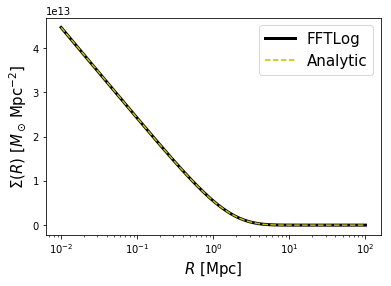

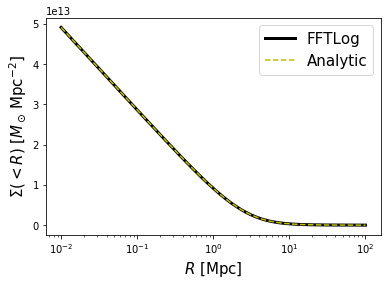

In [13]:
from scipy.special import kn

# Predictions
x = r_arr / rs
sR_pred = 1E14 / (2 * np.pi * rs**2) * kn(0, x)
slR_pred = 1E14 / (2 * np.pi * rs**2) * (2 / x**2) * (1 - x * kn(1, x))

# FFTlog calculation
sR = pl.projected(cosmo, r_arr, 1E14, a_sf, hmd_200c)
slR = pl.cumul2d(cosmo, r_arr, 1E14, a_sf, hmd_200c)

# Projected profile
plt.figure()
plt.plot(r_arr, sR,'k-', lw=3, label='FFTLog')
plt.plot(r_arr, sR_pred,'y--', label='Analytic')
plt.legend(loc='upper right', fontsize=15)
plt.ylabel(r'$\Sigma(R)\,\,[M_\odot\,{\rm Mpc}^{-2}]$', fontsize=15)
plt.xlabel(r'$R\,\,[{\rm Mpc}]$', fontsize=15);
plt.xscale('log')

# Cumulative surface density
plt.figure()
plt.plot(r_arr, slR,'k-', lw=3, label='FFTLog')
plt.plot(r_arr, slR_pred,'y--', label='Analytic')
plt.legend(loc='upper right', fontsize=15)
plt.ylabel(r'$\Sigma(<R)\,\,[M_\odot\,{\rm Mpc}^{-2}]$', fontsize=15)
plt.xlabel(r'$R\,\,[{\rm Mpc}]$', fontsize=15);
plt.xscale('log')